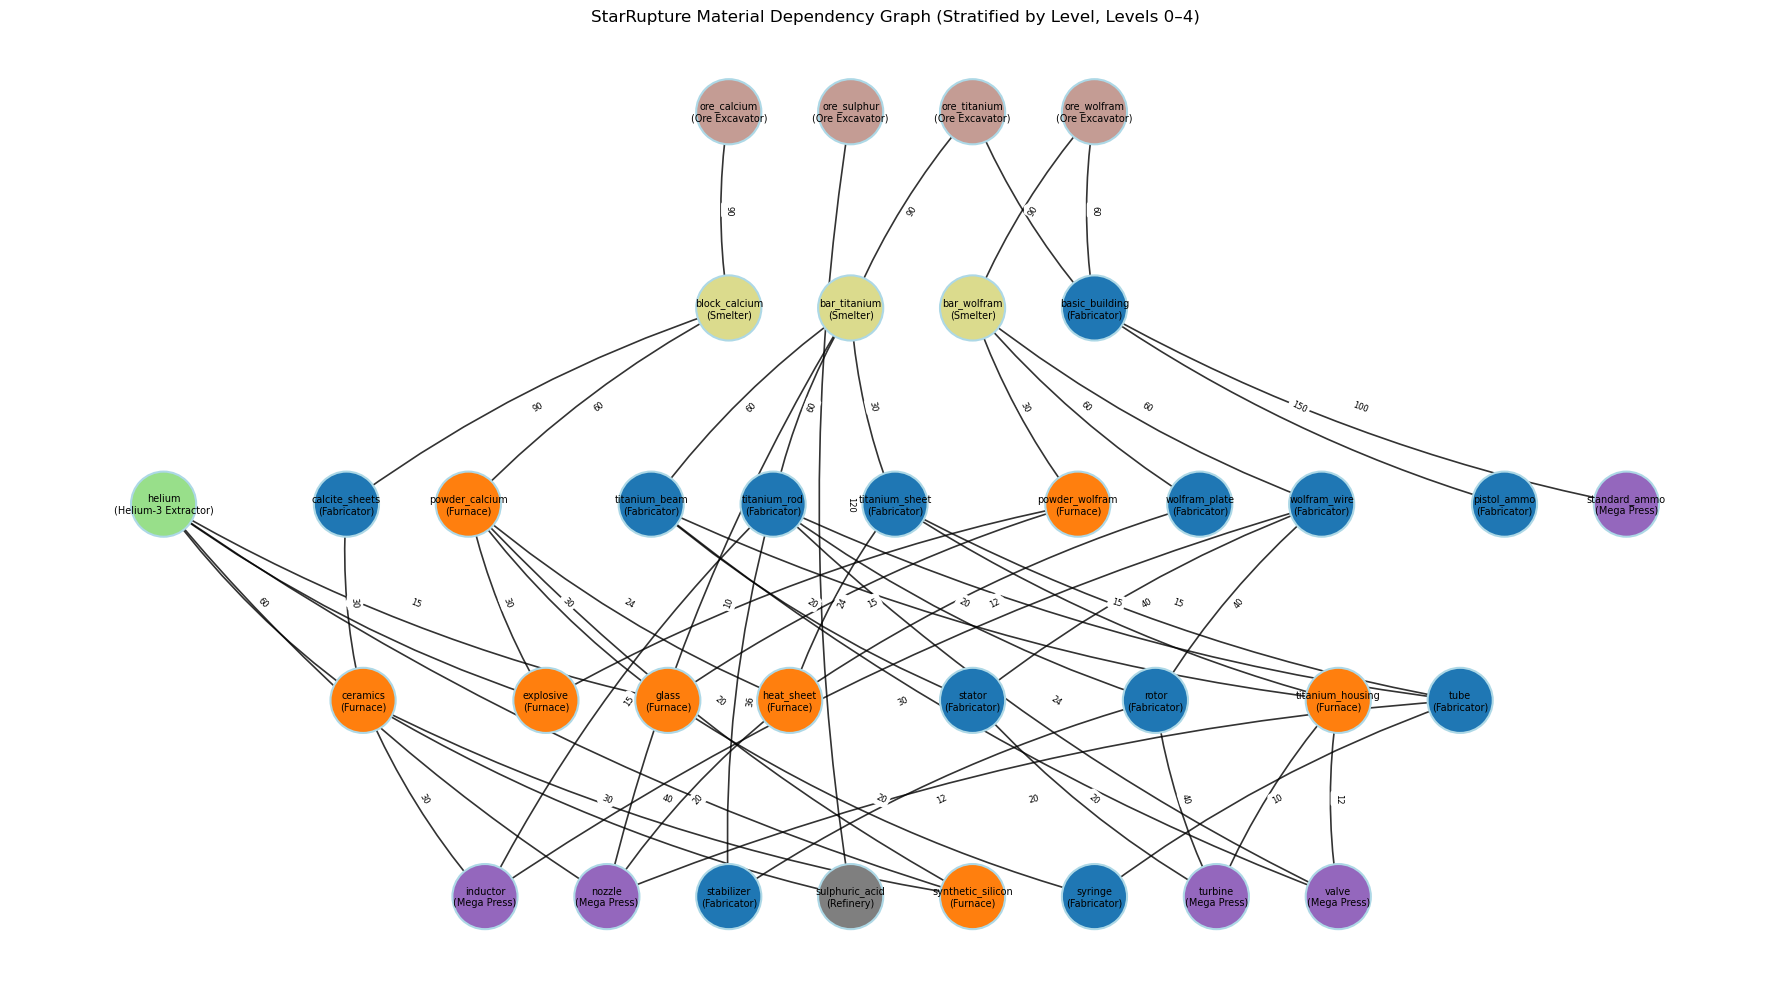

Level 0 (5 items):
  - helium
  - ore_calcium
  - ore_sulphur
  - ore_titanium
  - ore_wolfram

Level 1 (4 items):
  - bar_titanium
  - bar_wolfram
  - basic_building
  - block_calcium

Level 2 (10 items):
  - calcite_sheets
  - pistol_ammo
  - powder_calcium
  - powder_wolfram
  - standard_ammo
  - titanium_beam
  - titanium_rod
  - titanium_sheet
  - wolfram_plate
  - wolfram_wire

Level 3 (8 items):
  - ceramics
  - explosive
  - glass
  - heat_sheet
  - rotor
  - stator
  - titanium_housing
  - tube

Level 4 (8 items):
  - inductor
  - nozzle
  - stabilizer
  - sulphuric_acid
  - synthetic_silicon
  - syringe
  - turbine
  - valve



In [23]:
import json
import math
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt


JSON_PATH = "buildings_and_recipes.json"


def _extract_recipes(data):
    """
    Normalize recipes from the JSON into a list of dicts:
      {"machine": <str>, "output": <material>, "inputs": {material: qty, ...}}
    The JSON structure can vary; this function tries to be robust.
    """
    recipes = []

    # Common patterns I've seen in game recipe jsons:
    # - data["recipes"] : list of recipes
    # - data["buildings"][...]["recipes"] : list
    # - data["buildings_and_recipes"][...] etc.
    # We'll crawl recursively and collect anything that looks like a recipe.

    def looks_like_recipe(obj):
        if not isinstance(obj, dict):
            return False
        keys = set(obj.keys())
        # minimal indicators
        has_out = any(k in keys for k in ("output", "out", "result", "produces"))
        has_in = any(k in keys for k in ("inputs", "in", "ingredients", "requires", "cost"))
        return has_out and has_in

    def get_output(obj):
        for k in ("output", "out", "result", "produces"):
            if k in obj:
                out = obj[k]
                # Handle case where output is a dict with 'id' field
                if isinstance(out, dict) and "id" in out:
                    return out["id"]
                return out
        return None

    def get_inputs(obj):
        for k in ("inputs", "in", "ingredients", "requires", "cost"):
            if k in obj:
                return obj[k]
        return None

    def get_machine(obj):
        for k in ("machine", "building", "station", "producer"):
            if k in obj and isinstance(obj[k], str):
                return obj[k]
        return None

    def normalize_inputs(inp):
        # Accept formats:
        # - {"a": 2, "b": 1}
        # - [{"item":"a","amount":2}, ...]
        # - [{"id":"a","amount_per_minute":2}, ...]
        # - [["a",2], ["b",1]]
        if inp is None:
            return {}
        if isinstance(inp, dict):
            # Ensure numeric quantities; default 1 if weird
            norm = {}
            for k, v in inp.items():
                try:
                    norm[str(k)] = float(v)
                except Exception:
                    norm[str(k)] = 1.0
            return norm
        if isinstance(inp, list):
            norm = {}
            for el in inp:
                if isinstance(el, dict):
                    # Try to extract id/name and amount
                    item = el.get("id") or el.get("item") or el.get("name") or el.get("material")
                    amt = el.get("amount_per_minute") or el.get("amount") or el.get("qty") or el.get("count") or 1
                    if item is not None:
                        try:
                            norm[str(item)] = float(amt)
                        except Exception:
                            norm[str(item)] = 1.0
                elif isinstance(el, (list, tuple)) and len(el) >= 1:
                    item = el[0]
                    amt = el[1] if len(el) > 1 else 1
                    try:
                        norm[str(item)] = float(amt)
                    except Exception:
                        norm[str(item)] = 1.0
            return norm
        # unknown
        return {}

    def crawl(obj, current_machine=None):
        nonlocal recipes
        if isinstance(obj, dict):
            # If this dict names a machine/building, propagate it downward
            machine = current_machine
            for k in ("machine", "building", "station", "name", "id"):
                if k in obj and isinstance(obj[k], str):
                    # Heuristic: only treat it as a machine label if it appears to be a building-ish context
                    # Still safe to propagate; worst-case label is None/odd string.
                    machine = obj[k]
                    break

            if looks_like_recipe(obj):
                out = get_output(obj)
                inp = normalize_inputs(get_inputs(obj))
                m = get_machine(obj) or current_machine
                if out is not None:
                    recipes.append(
                        {
                            "machine": m,
                            "output": str(out),
                            "inputs": inp,
                        }
                    )

            for v in obj.values():
                crawl(v, machine)

        elif isinstance(obj, list):
            for v in obj:
                crawl(v, current_machine)

    crawl(data, None)

    # Deduplicate exact duplicates
    uniq = []
    seen = set()
    for r in recipes:
        key = (r["machine"], r["output"], tuple(sorted(r["inputs"].items())))
        if key not in seen:
            seen.add(key)
            uniq.append(r)
    return uniq


def compute_levels(recipes):
    """
    Compute levels for materials.
    Level 0: any recipe producing material has empty inputs.
    Otherwise: level(m) = min_over_recipes r producing m [ 1 + max(level(inputs of r)) ].
    Uses iterative relaxation; returns dict material -> int level (or None if unresolved).
    """
    produced_by = defaultdict(list)
    all_materials = set()

    for r in recipes:
        out = r["output"]
        ins = set(r["inputs"].keys())
        produced_by[out].append(r)
        all_materials.add(out)
        all_materials |= ins

    level = {m: None for m in all_materials}

    # Initialize gathered materials (any zero-input recipe)
    for m, rs in produced_by.items():
        if any(len(r["inputs"]) == 0 for r in rs):
            level[m] = 0

    # Iterative relaxation
    changed = True
    for _ in range(10_000):  # generous bound
        if not changed:
            break
        changed = False

        for m, rs in produced_by.items():
            # If already 0, keep it 0 (gathered)
            if level[m] == 0:
                continue

            candidates = []
            for r in rs:
                ins = r["inputs"]
                if len(ins) == 0:
                    candidates.append(0)
                    continue

                in_levels = []
                ok = True
                for i in ins.keys():
                    if level[i] is None:
                        ok = False
                        break
                    in_levels.append(level[i])
                if ok:
                    candidates.append(1 + max(in_levels))

            if candidates:
                new_lvl = min(candidates)
                if level[m] is None or new_lvl < level[m]:
                    level[m] = new_lvl
                    changed = True

    return level


def build_dependency_graph(recipes):
    """
    Build material dependency graph: edge input -> output
    Edge attributes: qty, machine
    If multiple recipes exist, multiple parallel edges would be needed;
    we store a list on the edge for readability by combining.
    """
    G = nx.DiGraph()
    for r in recipes:
        out = r["output"]
        G.add_node(out)
        for inp, qty in r["inputs"].items():
            G.add_node(inp)
            if G.has_edge(inp, out):
                G.edges[inp, out]["recipes"].append({"machine": r["machine"], "qty": qty})
            else:
                G.add_edge(inp, out, recipes=[{"machine": r["machine"], "qty": qty}])
    return G


def layered_positions(nodes_by_level, G):
    """
    Deterministic layered layout: each level is a horizontal row.
    For level 2, groups nodes by their level 1 inputs to show relationships.
    Helium is drawn at level 2 position even though it's level 0.
    Level 4 uses default alphabetical ordering.
    """
    pos = {}
    for lvl, nodes in sorted(nodes_by_level.items()):
        if lvl == 0:
            # Custom ordering for level 0: exclude helium (will be drawn at level 2)
            nodes_sorted = sorted(nodes)
            if "helium" in nodes_sorted:
                nodes_sorted.remove("helium")  # Don't position helium here
            n = len(nodes_sorted)
            for i, node in enumerate(nodes_sorted):
                x = i - (n - 1) / 2
                y = -lvl
                pos[node] = (x, y)
        elif lvl == 1:
            # Custom ordering for level 1: block_calcium at left, basic_building at right
            nodes_sorted = sorted(nodes)
            # Remove special nodes
            if "block_calcium" in nodes_sorted:
                nodes_sorted.remove("block_calcium")
            if "basic_building" in nodes_sorted:
                nodes_sorted.remove("basic_building")
            # Rebuild list with custom order: block_calcium first, others sorted, basic_building last
            final_order = []
            if "block_calcium" in nodes:
                final_order.append("block_calcium")
            final_order.extend(nodes_sorted)
            if "basic_building" in nodes:
                final_order.append("basic_building")
            
            n = len(final_order)
            for i, node in enumerate(final_order):
                x = i - (n - 1) / 2
                y = -lvl
                pos[node] = (x, y)
        elif lvl == 2:
            # Group level 2 nodes by their level 1 inputs
            groups = defaultdict(list)
            for node in nodes:
                # Find which level 1 node(s) this depends on
                predecessors = [p for p in G.predecessors(node) if G.nodes[p]["level"] == 1]
                if predecessors:
                    # Use the first predecessor as the grouping key
                    groups[predecessors[0]].append(node)
                else:
                    groups["_other"].append(node)
            
            # Custom ordering: calcite_sheets and powder_calcium at the left
            priority_nodes = ["calcite_sheets", "powder_calcium"]
            x_pos = 0
            group_spacing = 1.5  # Extra space between groups
            
            # First, position helium at the far left at level 2 (even though it's level 0)
            if "helium" in nodes_by_level.get(0, []):
                pos["helium"] = (x_pos, -2)  # Draw at level 2 position
                x_pos += 1
                x_pos += group_spacing - 1
            
            # Then position calcite_sheets and powder_calcium
            for pnode in priority_nodes:
                if pnode in nodes:
                    pos[pnode] = (x_pos, -lvl)
                    x_pos += 1
            if any(pnode in nodes for pnode in priority_nodes):
                x_pos += group_spacing - 1  # Add spacing after priority nodes
            
            # Then position other grouped nodes
            for group_key in sorted(groups.keys()):
                group_nodes = sorted(groups[group_key])
                # Skip priority nodes as they're already positioned
                group_nodes = [n for n in group_nodes if n not in priority_nodes]
                for node in group_nodes:
                    pos[node] = (x_pos, -lvl)
                    x_pos += 1
                if group_nodes:  # Only add spacing if we added nodes
                    x_pos += group_spacing - 1
            
            # Center the entire level around x=0
            if pos:
                x_values = [p[0] for p in pos.values() if p[1] == -lvl]
                if x_values:
                    x_offset = sum(x_values) / len(x_values)
                    for node in nodes:
                        if node in pos:
                            pos[node] = (pos[node][0] - x_offset, pos[node][1])
                    # Also adjust helium position
                    if "helium" in pos:
                        pos["helium"] = (pos["helium"][0] - x_offset, pos["helium"][1])
        elif lvl == 3:
            # Group level 3 nodes by their level 2 inputs for clearer visualization
            groups = defaultdict(list)
            for node in nodes:
                # Find which level 2 node(s) this depends on
                predecessors = [p for p in G.predecessors(node) if G.nodes[p]["level"] == 2]
                if predecessors:
                    # Check if node only depends on titanium products
                    titanium_inputs = [p for p in predecessors if p.startswith("titanium_")]
                    if titanium_inputs and len(titanium_inputs) == len(predecessors):
                        # Only titanium inputs
                        groups["_titanium_only"].append(node)
                    else:
                        # Use first predecessor as grouping key
                        groups[predecessors[0]].append(node)
                else:
                    groups["_other"].append(node)
            
            # Order groups and position nodes with spacing between groups
            x_pos = 0
            group_spacing = 1.5  # Extra space between groups
            
            # First position non-titanium-only nodes
            for group_key in sorted(groups.keys()):
                if group_key == "_titanium_only":
                    continue  # Skip titanium-only for now
                group_nodes = sorted(groups[group_key])
                for node in group_nodes:
                    pos[node] = (x_pos, -lvl)
                    x_pos += 1
                if group_nodes:
                    x_pos += group_spacing - 1
            
            # Then position titanium-only nodes (titanium_housing, tube) in the middle area
            if "_titanium_only" in groups:
                # Position these after the left groups but before right groups
                # For simplicity, we'll place them after other groups
                titanium_nodes = sorted(groups["_titanium_only"])
                for node in titanium_nodes:
                    pos[node] = (x_pos, -lvl)
                    x_pos += 1
            
            # Center the entire level around x=0
            if pos:
                x_values = [p[0] for p in pos.values() if p[1] == -lvl]
                if x_values:
                    x_offset = sum(x_values) / len(x_values)
                    for node in nodes:
                        if node in pos:
                            pos[node] = (pos[node][0] - x_offset, pos[node][1])
        else:
            # Default alphabetical ordering for other levels (level 4+)
            nodes = sorted(nodes)
            n = len(nodes)
            for i, node in enumerate(nodes):
                x = i - (n - 1) / 2
                y = -lvl
                pos[node] = (x, y)
    return pos


def main():
    with open(JSON_PATH, "r") as f:
        data = json.load(f)

    recipes = _extract_recipes(data)
    if not recipes:
        raise RuntimeError("No recipes detected in JSON (unexpected structure).")

    levels = compute_levels(recipes)
    G_full = build_dependency_graph(recipes)

    # Keep only materials with resolved levels
    resolved = {m: lvl for m, lvl in levels.items() if isinstance(lvl, int)}
    # Restrict to levels <= 4
    keep = {m for m, lvl in resolved.items() if lvl <= 4}

    G = G_full.subgraph(keep).copy()

    # Attach level as node attribute
    nx.set_node_attributes(G, {m: resolved[m] for m in G.nodes()}, "level")
    
    # Attach machine info to each node (which machine produces it)
    material_to_machine = {}
    for r in recipes:
        material_to_machine[r["output"]] = r["machine"] or "Gathered"
    nx.set_node_attributes(G, material_to_machine, "machine")

    # Group nodes by level
    nodes_by_level = defaultdict(list)
    for n in G.nodes():
        nodes_by_level[G.nodes[n]["level"]].append(n)

    # Build positions that respect stratification and group level 2 by inputs
    pos = layered_positions(nodes_by_level, G)

    # Draw
    plt.figure(figsize=(18, 10))

    # Color nodes by machine type
    all_machines = list(set(material_to_machine.values()))
    all_machines.sort()  # Consistent ordering
    machine_to_color_idx = {m: i for i, m in enumerate(all_machines)}
    
    node_colors = []
    for n in G.nodes():
        machine = G.nodes[n].get("machine", "Unknown")
        node_colors.append(machine_to_color_idx.get(machine, 0))
    
    nx.draw_networkx_nodes(
        G, pos,
        node_size=2200,
        node_color=node_colors,
        cmap=plt.cm.tab20,
        vmin=0,
        vmax=len(all_machines),
        linewidths=1.5,
        edgecolors="lightblue",
    )

    # Create labels with machine names in italics
    labels = {}
    for n in G.nodes():
        machine = G.nodes[n].get("machine", "Unknown")
        labels[n] = f"{n}\n({machine})" if machine != "Gathered" else n
    
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)

    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle="->",
        arrowsize=14,
        width=1.2,
        alpha=0.8,
        connectionstyle="arc3,rad=0.08",  # slight curvature helps overlap
    )

    # Edge labels show only quantities (no machine names)
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        rs = d.get("recipes", [])
        if len(rs) == 1:
            q = rs[0]["qty"]
            edge_labels[(u, v)] = f"{q:g}"
        else:
            # Multiple recipes - show count
            edge_labels[(u, v)] = f"{len(rs)} recipes"

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.title("StarRupture Material Dependency Graph (Stratified by Level, Levels 0–4)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print level lists (0–4) for reference
    for lvl in range(0, 5):
        items = sorted([m for m, L in resolved.items() if L == lvl])
        print(f"Level {lvl} ({len(items)} items):")
        for m in items:
            print(f"  - {m}")
        print()


if __name__ == "__main__":
    main()

In [21]:
# Check what level electronics is at
print("Electronics level:", levels_dict.get("electronics"))
print()

# Find recipes that produce electronics
print("Recipes that produce electronics:")
for r in recipes:
    if r["output"] == "electronics":
        print(f"  Machine: {r['machine']}")
        print(f"  Inputs: {r['inputs']}")
print()

# Find recipes that use electronics as input
print("Recipes that use electronics as input:")
found_any = False
for r in recipes:
    if "electronics" in r["inputs"]:
        print(f"  Output: {r['output']}")
        print(f"  Machine: {r['machine']}")
        print(f"  Input qty: {r['inputs']['electronics']}")
        found_any = True
if not found_any:
    print("  (none found)")


Electronics level: 5

Recipes that produce electronics:
  Machine: Fabricator
  Inputs: {'synthetic_silicon': 24.0, 'powder_wolfram': 12.0}

Recipes that use electronics as input:
  (none found)


## Backup: Levels 0–3 Visualization (Original)

In [ ]:
def main_levels_0_to_3():
    """
    Backup: Original visualization showing levels 0–3 only.
    Call this to recreate the original stratified graph.
    """
    with open(JSON_PATH, "r") as f:
        data = json.load(f)

    recipes = _extract_recipes(data)
    if not recipes:
        raise RuntimeError("No recipes detected in JSON (unexpected structure).")

    levels = compute_levels(recipes)
    G_full = build_dependency_graph(recipes)

    # Keep only materials with resolved levels
    resolved = {m: lvl for m, lvl in levels.items() if isinstance(lvl, int)}
    # Restrict to levels <= 3
    keep = {m for m, lvl in resolved.items() if lvl <= 3}

    G = G_full.subgraph(keep).copy()

    # Attach level as node attribute
    nx.set_node_attributes(G, {m: resolved[m] for m in G.nodes()}, "level")

    # Group nodes by level
    nodes_by_level = defaultdict(list)
    for n in G.nodes():
        nodes_by_level[G.nodes[n]["level"]].append(n)

    # Build positions that respect stratification and group level 2 by inputs
    pos = layered_positions(nodes_by_level, G)

    # Draw
    plt.figure(figsize=(18, 10))

    # Color nodes by level (use much lighter blue range for better label readability)
    node_colors = [G.nodes[n]["level"] for n in G.nodes()]
    nx.draw_networkx_nodes(
        G, pos,
        node_size=1600,
        node_color=node_colors,
        cmap=plt.cm.Blues,
        vmin=-2,  # Shift color range to use much lighter blues
        vmax=5,
        linewidths=1.0,
        edgecolors="black",
    )

    nx.draw_networkx_labels(G, pos, font_size=8)

    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle="->",
        arrowsize=14,
        width=1.2,
        alpha=0.8,
        connectionstyle="arc3,rad=0.08",  # slight curvature helps overlap
    )

    # Optional: edge labels (can get cluttered). Here we show summed qty if unambiguous.
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        # If multiple recipes contribute, show a compact summary
        rs = d.get("recipes", [])
        if len(rs) == 1:
            q = rs[0]["qty"]
            m = rs[0]["machine"] or "?"
            edge_labels[(u, v)] = f"{q:g} ({m})"
        else:
            # e.g., "2x" recipes; or show first machine
            edge_labels[(u, v)] = f"{len(rs)} recipes"

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.title("StarRupture Material Dependency Graph (Stratified by Level, Levels 0–3)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print level lists (0–3) for reference
    for lvl in range(0, 4):
        items = sorted([m for m, L in resolved.items() if L == lvl])
        print(f"Level {lvl} ({len(items)} items):")
        for m in items:
            print(f"  - {m}")
        print()
